# Find if a loan will be paidoff or not

## Notebook focuses on the Paidoff

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn import preprocessing, svm

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import jaccard_score, f1_score, log_loss, precision_score, recall_score

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(style="darkgrid")

%matplotlib inline

### About dataset

This dataset is about past loans. The data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Loan is paid off on in collection                                                     |
| Principal      | Principal loan amount                                                                 |
| Terms          | Payment Cycle                           |
| Effective_date | Loan start date                                                                       |
| Due_date       | Loan repayment date                                                                   |
| Age            | Age of borrower                                                                       |
| Education      | Education of borrower                                                                 |
| Gender         | Gender of borrower.                                                                   |

### Load Data From CSV File  

In [2]:
df = pd.read_csv('loan_train.csv')
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,09/08/16,10/07/16,45,High School or Below,male
1,PAIDOFF,1000,30,09/08/16,10/07/16,33,Bechalor,female
2,PAIDOFF,1000,15,09/08/16,9/22/2016,27,college,male
3,PAIDOFF,1000,30,09/09/16,10/08/16,28,college,female
4,PAIDOFF,1000,30,09/09/16,10/08/16,29,college,male


In [3]:
df.shape

(346, 8)

### Convert to date time object 

In [4]:
df[['due_date', 'effective_date']] = df[['due_date', 'effective_date']].apply(lambda x: pd.to_datetime(x))

df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data Visualization



In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 borrowers have promptly repaid the loan, while 86 have entered the collection process.

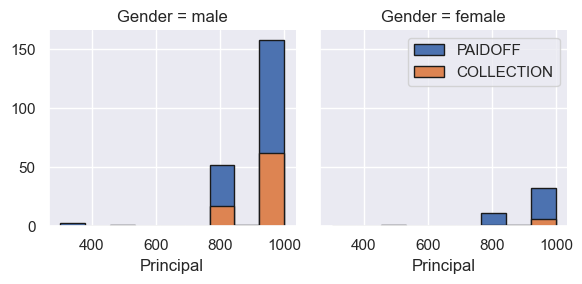

In [6]:
def plot_gender_column(column_name):
    bins = np.linspace(df[column_name].min(), df[column_name].max(), 10)
    
    gender_column = (sns.FacetGrid(df, col="Gender",hue="loan_status", col_wrap=2))
    
    gender_column.map(plt.hist, column_name, bins=bins, ec="k")
    gender_column.axes[-1].legend()
    plt.show()

plot_gender_column('Principal')



Major borrowers have principal amount > 600

Male borrow more than Female

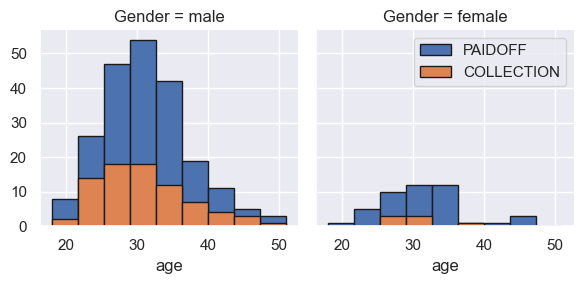

In [7]:
plot_gender_column('age')

Male tend to borrow between the age of 20 & 40

Female borrow between the age of 25 & 35

# Pre-processing:  Feature selection/extraction

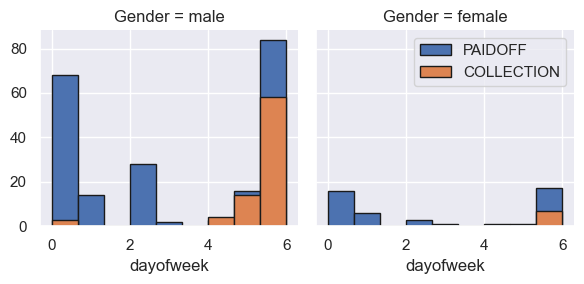

In [8]:
df['dayofweek'] = df['effective_date'].dt.dayofweek

plot_gender_column('dayofweek')

We see that borrowers who receive loans at the end of the week do not repay them, so let's utilise feature binarization to establish a threshold value lower than day 4.

# Pre-Processing

In [9]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

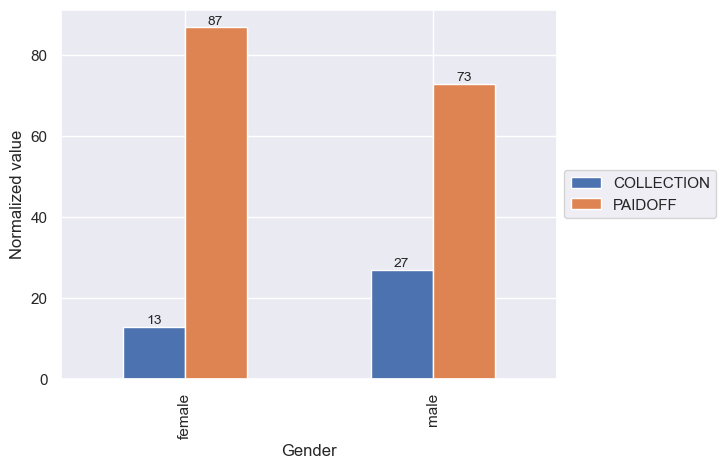

In [10]:
gender = (df.groupby(['Gender'])['loan_status']
          .value_counts(normalize=True).mul(100).round(0))

gender = gender.unstack()

# plot bar chart
ax = gender.plot(kind='bar')
ax.set_xlabel('Gender')
ax.set_ylabel('Normalized value')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=10)

plt.show()

87 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [11]:
gender_mapping = {'male': 0, 'female': 1}
df['Gender'] = df['Gender'].map(gender_mapping)

df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1



#### Explore Education

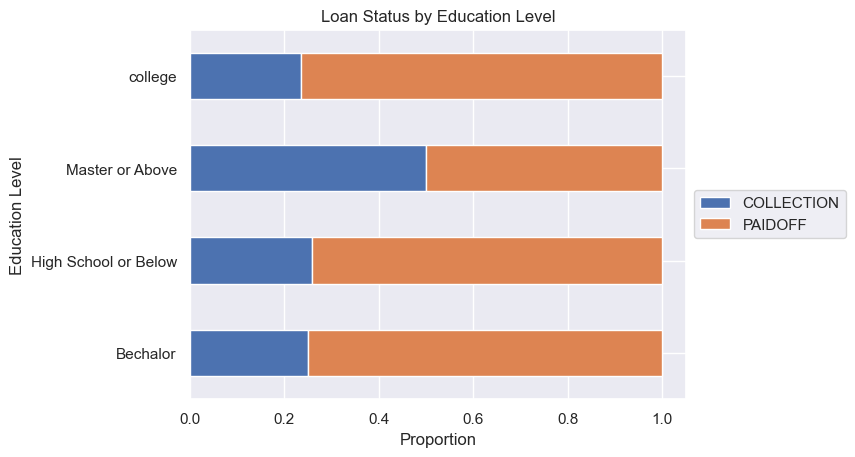

In [12]:
(df.groupby(['education'])['loan_status'].value_counts(normalize=True)
 .unstack().plot(kind='barh', stacked=True))
    
plt.xlabel('Proportion')
plt.ylabel('Education Level')
plt.title('Loan Status by Education Level')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We see that for Master or Above, the probability of Collection is higher, since we are only looking for paidoff we will remove Master or Above category)

## One Hot Encoding  

#### Data before One Hot Encoding

In [13]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### One hot encoding to convert categorical to binary data

In [14]:
X = (df[['Principal','terms','age','Gender','weekend']]
           .join(pd.get_dummies(df['education']))
           .drop('Master or Above', axis=1))
X.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection & Normalization

### When data are standardised, their mean and variance are both zero

In [15]:
y = df['loan_status'].values
X = preprocessing.StandardScaler().fit(X).transform(X)

# Classification 

### Train Test Split

In [16]:
X_train, X_test, y_train, y_test = (train_test_split(X, y,test_size=0.3, random_state=42))


# K Nearest Neighbour(KNN)


#### Building model using KNN, finding the best k and accuracy evaluation

Accuracy for k = 1 : 69.39
Accuracy for k = 2 : 57.14
Accuracy for k = 3 : 72.45
Accuracy for k = 4 : 61.46
Accuracy for k = 5 : 68.63
Accuracy for k = 6 : 68.42
Accuracy for k = 7 : 67.65
Accuracy for k = 8 : 65.66
Accuracy for k = 9 : 70.59


Text(0, 0.5, 'Testing Accuracy')

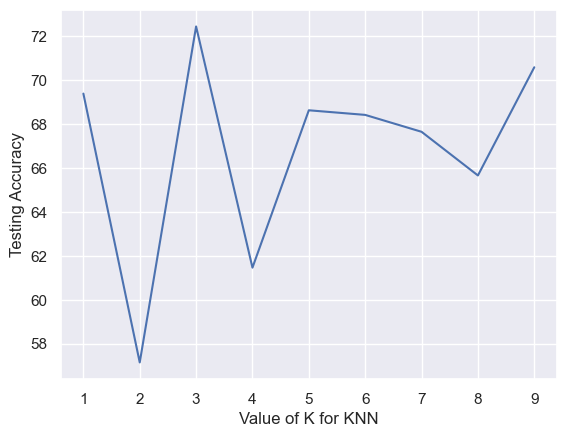

In [17]:
# We can use GridSeachCV but to show impact of k on accuracy
# We are doing manual traversal

accuracy_score = []


k_range = range(1,10)

for k in k_range:
    
    KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    knn_yhat = KNN.predict(X_test)
    accuracy = round(jaccard_score(y_test, knn_yhat, pos_label="PAIDOFF")*100,2)
    
    print("Accuracy for k =", k, ":", accuracy)
    
    accuracy_score.append(accuracy)


plt.plot(k_range, accuracy_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

#### K = 3 is the best let's try it !

In [18]:
# perform the test
KNN = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)
KNN

KNeighborsClassifier(n_neighbors=3)

# Support Vector Machine

#### Building model using SVM, finding the best k and accuracy evaluation

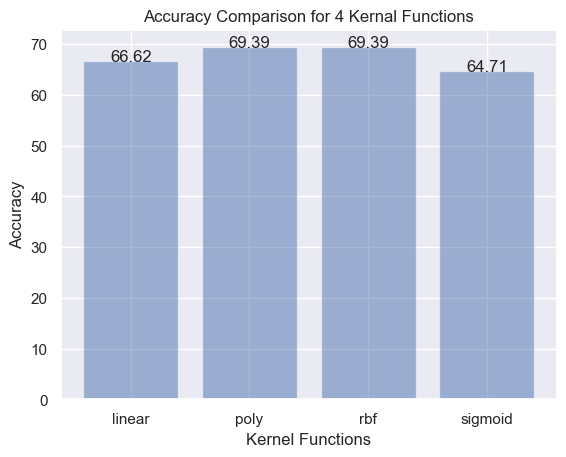

In [19]:
func_list = ['linear', 'poly', 'rbf', 'sigmoid']
accuracy_score = []

for func in func_list:
    
    SVM = svm.SVC(kernel=func)
    
    SVM.fit(X_train, y_train)
    
    svm_yhat = SVM.predict(X_test)
    
    accuracy_score.append(f1_score(y_test, svm_yhat, average='weighted')*100)

    
y_pos = np.arange(len(func_list))
plt.bar(y_pos, accuracy_score, align='center', alpha=0.5)
plt.xticks(y_pos, func_list)
plt.ylabel('Accuracy')
plt.xlabel('Kernel Functions')
plt.title('Accuracy Comparison for 4 Kernal Functions')

# Add values on top of the bars
for i, v in enumerate(accuracy_score):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')

plt.show()


####  rbf & poly have same score. For now let's try rbf

In [20]:


SVM = svm.SVC(kernel='rbf')

SVM.fit(X_train, y_train)
SVM

SVC()

# Logistic Regression

#### Building model using Logistic Regression, finding the best c & solver


Parameter : 1, Accuracy for C = 0.1,solver = newton-cg : 50.25
Parameter : 2, Accuracy for C = 0.1,solver = lbfgs : 50.25
Parameter : 3, Accuracy for C = 0.1,solver = liblinear : 51.74
Parameter : 4, Accuracy for C = 0.1,solver = sag : 50.25
Parameter : 5, Accuracy for C = 0.1,solver = saga : 50.25

Parameter : 6, Accuracy for C = 0.01,solver = newton-cg : 49.57
Parameter : 7, Accuracy for C = 0.01,solver = lbfgs : 49.57
Parameter : 8, Accuracy for C = 0.01,solver = liblinear : 58.54
Parameter : 9, Accuracy for C = 0.01,solver = sag : 49.57
Parameter : 10, Accuracy for C = 0.01,solver = saga : 49.57

Parameter : 11, Accuracy for C = 0.001,solver = newton-cg : 51.8
Parameter : 12, Accuracy for C = 0.001,solver = lbfgs : 51.8
Parameter : 13, Accuracy for C = 0.001,solver = liblinear : 67.31
Parameter : 14, Accuracy for C = 0.001,solver = sag : 51.8
Parameter : 15, Accuracy for C = 0.001,solver = saga : 51.8


Text(0, 0.5, 'Testing Accuracy')

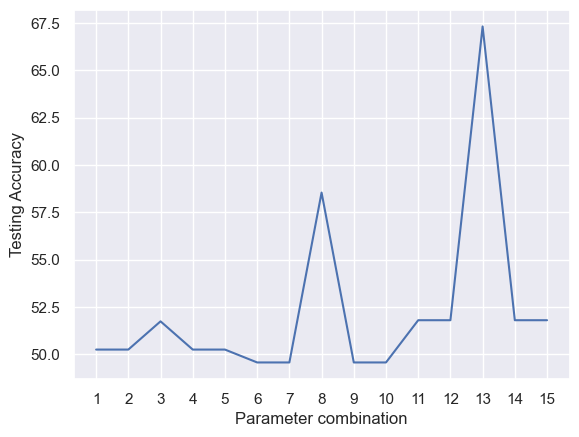

In [21]:
c_list = [0.1, 0.01, 0.001]

solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

accuracy_score = []

parameter = 0

for c in c_list:
    print()
    for sol in solver_list:
        
        LR = LogisticRegression(C=c, solver=sol).fit(X_train, y_train)
        
        lr_prob = LR.predict_proba(X_test)
        
        loss = round(log_loss(y_test, lr_prob)*100,2)
        
        accuracy_score.append(loss)
        
        parameter += 1
        
        print(f'Parameter : {parameter}, Accuracy for C = {c},solver = {sol} : {loss}')

plt.plot(np.arange(len(accuracy_score)), accuracy_score)
plt.xticks(np.arange(len(accuracy_score)), np.arange(1, len(accuracy_score)+1))
plt.xlabel('Parameter combination')
plt.ylabel('Testing Accuracy')


####  c = 0.001 and solver = liblinear gives the highest accuracy

In [22]:
LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train, y_train)
LR

LogisticRegression(C=0.001, solver='liblinear')

# Model Evaluation using Test

### Load Test Data

In [23]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,09/08/16,10/07/16,50,Bechalor,female
1,PAIDOFF,300,7,09/09/16,9/15/2016,35,Master or Above,male
2,PAIDOFF,1000,30,09/10/16,10/09/16,43,High School or Below,female
3,PAIDOFF,1000,30,09/10/16,10/09/16,26,college,male
4,PAIDOFF,800,15,09/11/16,9/25/2016,29,Bechalor,male


### Data pre-processing and Selection
Same as we did above while training

In [24]:
test_df = pd.read_csv('loan_test.csv', parse_dates=['due_date', 'effective_date'])

# convert date time
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

# evaulate weekend field
test_df['weekend'] = np.where(test_df['dayofweek'] > 3, 1, 0)

# One Hot Encoding
test_df['Gender'] = test_df['Gender'].map({'male': 0, 'female': 1})

# Education level
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)

# Testing Feature & Normalize the test data
X_loan_test = preprocessing.StandardScaler().fit_transform(test_feature)


# Target Result
y_loan_test = test_df['loan_status'].values

# Prediction & Accuracy

We will calculate :

1. Jaccard
2. F1
3. Precision
4. Recall

In [25]:
jaccard = {}
f1 = {}
precision = {}
recall = {}

models = [KNN, SVM, LR]
model_name = ["KNN", "SVM", "LR"]

for i in range(len(models)):
    
    prediction = models[i].predict(X_loan_test)
    
    jaccard[model_name[i]] = jaccard_score(y_loan_test, prediction, pos_label="PAIDOFF")
    
    f1[model_name[i]] = f1_score(y_loan_test, prediction, pos_label="PAIDOFF")
    
    precision[model_name[i]] = precision_score(y_loan_test, prediction, pos_label="PAIDOFF")
    
    recall[model_name[i]] = recall_score(y_loan_test, prediction, pos_label="PAIDOFF")





# Visualize Score

### Heatmap

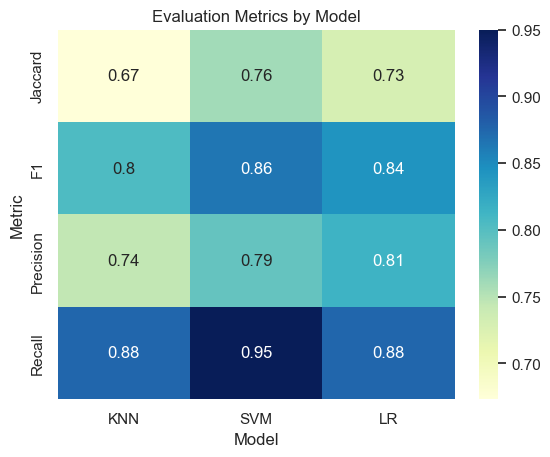

In [26]:
# Create a heatmap
labels = ['KNN', 'SVM', 'LR']
metrics = ['Jaccard', 'F1', 'Precision', 'Recall']
values = np.array([[jaccard[model] for model in labels],
                   [f1[model] for model in labels],
                   [precision[model] for model in labels],
                   [recall[model] for model in labels]])

fig, ax = plt.subplots()
sns.heatmap(values, annot=True, cmap='YlGnBu', xticklabels=labels, yticklabels=metrics, ax=ax)
ax.set_title('Evaluation Metrics by Model')
ax.set_xlabel('Model')
ax.set_ylabel('Metric')
plt.show()


Above heatmap shows that SVM dominates in Jaccard, F1, & Recall.

Although LR & KNN are not too far away from SVM result.

Let's group the result for better understanding

### Grouped Bar Chart

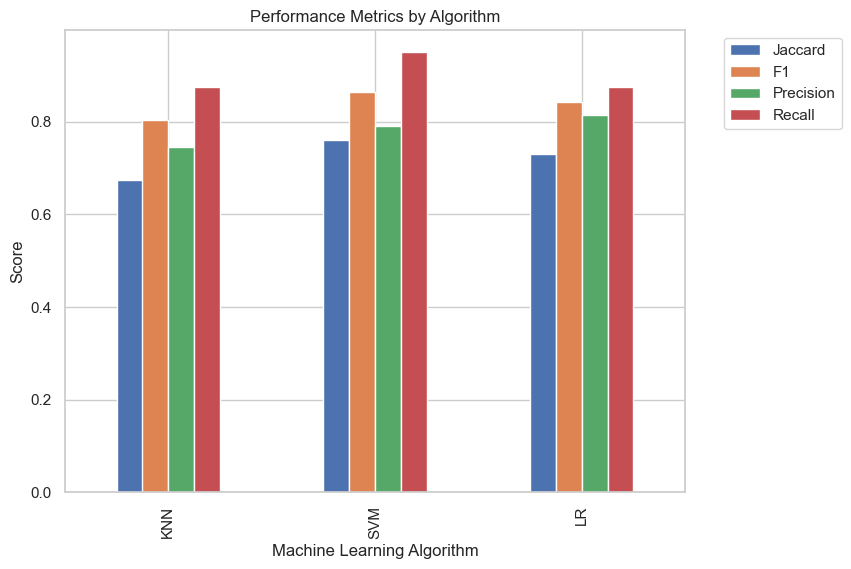

In [27]:
df_jaccard = pd.DataFrame.from_dict(jaccard, orient='index', columns=['Jaccard'])
df_f1 = pd.DataFrame.from_dict(f1, orient='index', columns=['F1'])
df_precision = pd.DataFrame.from_dict(precision, orient='index', columns=['Precision'])
df_recall = pd.DataFrame.from_dict(recall, orient='index', columns=['Recall'])
df = pd.concat([df_jaccard, df_f1, df_precision, df_recall], axis=1)

# Create a grouped bar plot using seaborn
sns.set_style("whitegrid")
ax = df.plot(kind='bar', figsize=(8,6))
ax.set_xlabel('Machine Learning Algorithm')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics by Algorithm')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Show the plot
plt.show()


Above chart is a better visualization of heatmap we saw.

We need to stack all the scores to get a view of all the scores combined

### Stacked Bar Chart

<Axes: >

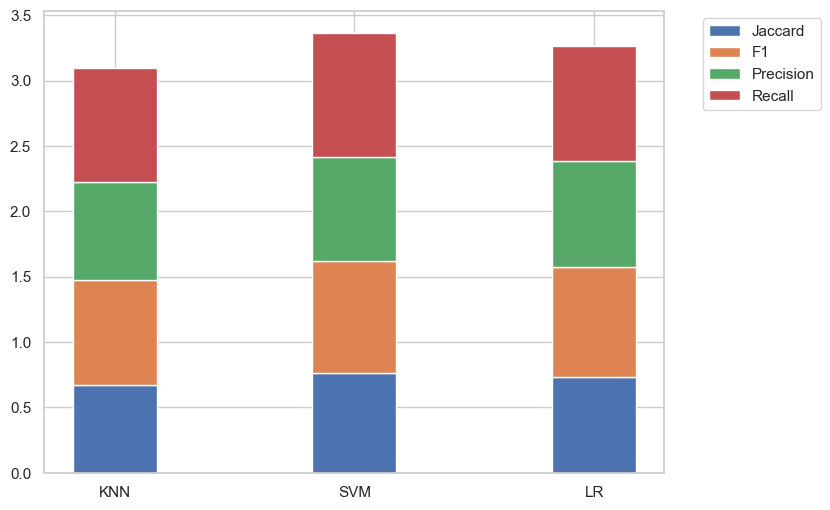

In [28]:

# Convert the dictionaries to lists
jaccard_values = list(jaccard.values())
f1_values = list(f1.values())
precision_values = list(precision.values())
recall_values = list(recall.values())

# Create a stacked bar plot using matplotlib
fig, ax = plt.subplots(figsize=(8,6))
ind = np.arange(len(jaccard_values))
width = 0.35
p1 = ax.bar(ind, jaccard_values, width, label='Jaccard')
p2 = ax.bar(ind, f1_values, width, bottom=jaccard_values, label='F1')
p3 = ax.bar(ind, precision_values, width, bottom=np.array(jaccard_values)+np.array(f1_values), label='Precision')
p4 = ax.bar(ind, recall_values, width, bottom=np.array(jaccard_values)+np.array(f1_values)+np.array(precision_values), label='Recall')
ax.set_xticks(ind)
ax.set_xticklabels(list(jaccard.keys()))
ax.legend(['Jaccard', 'F1', 'Precision', 'Recall'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax


Maximum value possible is 4, we see all model falling between 3 & 3.5.

By stacking the score together we see that KNN scores lesser than SVM & LR

### Line Chart

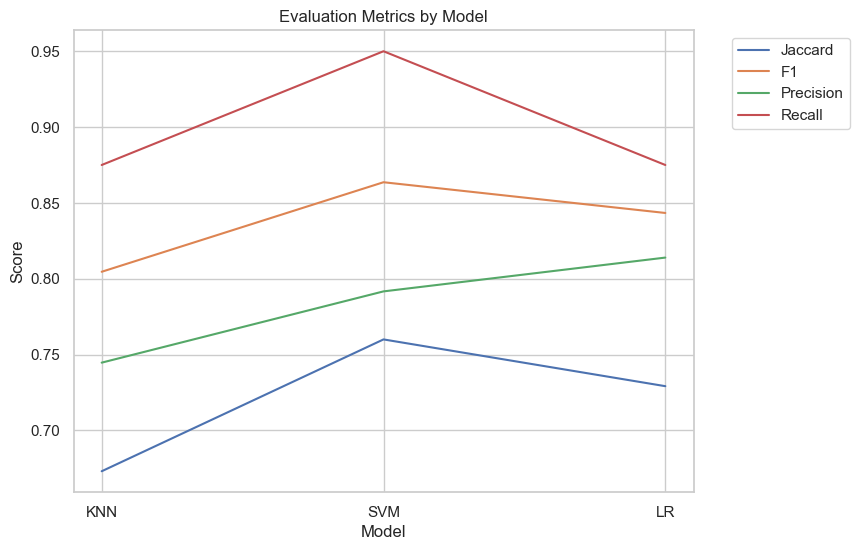

In [29]:
# Create a line chart
labels = ['KNN', 'SVM', 'LR']
values = [jaccard, f1, precision, recall]

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(labels, jaccard_values, label="Jaccard")
ax.plot(labels, f1_values, label="F1")
ax.plot(labels, precision_values, label="Precision")
ax.plot(labels, recall_values, label="Recall")

ax.set_title('Evaluation Metrics by Model')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Above charts shows trend of individual scores for different model.

Looking at the Jaccard index, which measures the similarity between the predicted labels and the true labels, SVM has the highest score of 0.76, followed by Logistic Regression with a score of 0.73, and then KNN with a score of 0.67. This suggests that SVM and Logistic Regression are better at predicting the loan repayment status compared to KNN.

In terms of the F1 score, which is the harmonic mean of precision and recall, SVM has the highest score of 0.86, followed by Logistic Regression with a score of 0.84, and then KNN with a score of 0.8. This suggests that SVM and Logistic Regression have better balance between precision and recall compared to KNN.

Looking at precision, which measures the proportion of true positives among all predicted positives, Logistic Regression has the highest score of 0.81, followed by KNN with a score of 0.74, and then SVM with a score of 0.79. This suggests that Logistic Regression is better at identifying true positives among all predicted positives.

In terms of recall, which measures the proportion of true positives among all actual positives, SVM has the highest score of 0.95, followed by KNN with a score of 0.88, and then Logistic Regression with a score of 0.88. This suggests that SVM is better at identifying all actual positives.

Overall, SVM appears to be the best model for this particular problem based on the evaluation metrics.


